In [49]:
import math
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from tqdm import tqdm
from PIL import Image

# Preparing data

In [50]:
train_dataset = MNIST(root="data", download=True, transform=ToTensor())
test_dataset = MNIST(root="data", download=True, train=False, transform=ToTensor())
train_data = DataLoader(train_dataset, batch_size=64)
test_data = DataLoader(test_dataset, batch_size=64)

In [51]:
image, label = train_dataset[10]

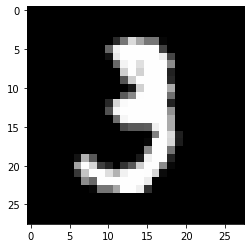

In [52]:
plt.imshow(image.numpy()[0], cmap="gray", vmin=0, vmax=1)
plt.show()

# Defining spiking dynamics

In [54]:
# Membrane time constant
T_RC = 0.02
T_REF = 4e-3
V_TH = 1.0

def rate(x, p=torch.relu, t_rc = T_RC, t_ref = T_REF, V_th = V_TH):
  return torch.reciprocal(t_ref + t_rc * torch.log(1 + V_th / (p(x - V_th) + 1e-12)))

def soft_rate(x, t_rc = T_RC, t_ref = T_REF, V_th = V_TH):
  return rate(x, p=lambda x: torch.nn.functional.softplus(x, beta=20), t_rc=t_rc, t_ref=t_ref, V_th=V_th)

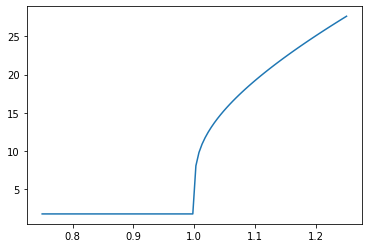

In [55]:
x = torch.linspace(0.75, 1.25, 100)
y = rate(x)
plt.plot(x, y)
plt.show()

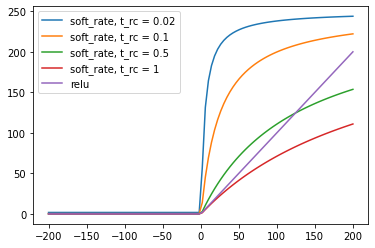

In [56]:
x = torch.linspace(-200, 200, 100)
rcs = [T_RC, 0.1, 0.5, 1]
ys = [(rc, rate(x, t_rc=rc)) for rc in rcs]
y2 = torch.relu(x)


for (rc, y) in ys:
  plt.plot(x, y)

plt.plot(x, y2)
plt.legend( ["soft_rate, t_rc = " + str(rc) for rc in rcs] + ["relu"])

plt.show()

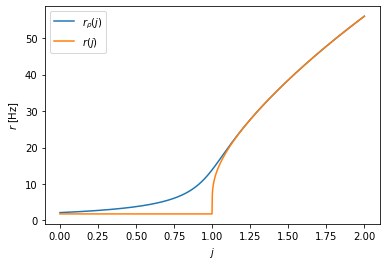

In [57]:
x = torch.linspace(0., 1.25, 100)
x = torch.linspace(0.6, 1.4, 1000)
x = torch.linspace(0, 2, 1000)
y = soft_rate(x)
y2 = rate(x)
plt.plot(x, y)
plt.plot(x, y2)
plt.ylabel("$r$ [Hz]")
plt.xlabel("$j$")
plt.legend([r"$r_{\rho}(j)$", r"$r(j)}$"])
plt.show()

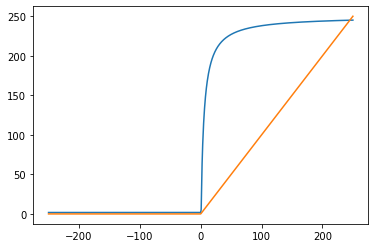

In [58]:
x = torch.linspace(-250, 250, 1000)
y = soft_rate(x)
y2 = torch.relu(x)
plt.plot(x, y)
plt.plot(x, y2)
plt.show()

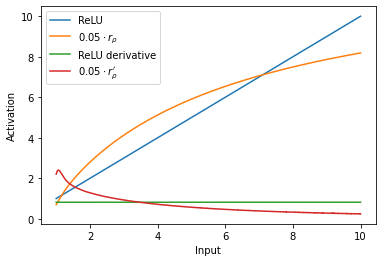

In [59]:
start = -1
stop = 10
steps = 10000
x = torch.linspace(-start, stop, steps)
y = torch.relu(x)
y2 = soft_rate(x) * 0.05

plt.plot(x, y)
plt.plot(x, y2)
plt.plot(x[1:], (y[1:] - y[:-1]) / ((stop - start) / steps))
plt.plot(x[1:], (y2[1:] - y2[:-1]) / ((stop - start) / steps))
plt.legend([
  "ReLU",
  "$0.05 \cdot r_\\rho$",
  "ReLU derivative",
  "$0.05 \cdot r_\\rho^\prime$",
])
plt.xlabel("Input")
plt.ylabel("Activation")
plt.show()

# Define models

In [68]:
import math
# Use this a activation function
class SoftSpikeRate(nn.Module):
  def __init__(self, t_rc=T_RC, t_ref=T_REF, V_th=V_TH):
    super(SoftSpikeRate, self).__init__()
    self.t_rc = torch.tensor(t_rc)
    self.t_ref = torch.tensor(t_ref)
    self.V_th = torch.tensor(V_th)
  
  def forward(self, X):
    return soft_rate(X, t_rc=self.t_rc, t_ref=self.t_ref, V_th=self.V_th)

class SpikingLinear(nn.Module):
  def __init__(self, in_features, out_features):
    super(SpikingLinear, self).__init__()
    # Initialize our weights
    g = T_REF / in_features
    mean = 10 * g
    std = 0.2 * math.sqrt(g)
    self.weight = nn.Parameter(torch.randn(in_features, out_features) * std + mean)
    self.bias = nn.Parameter(torch.zeros(out_features))

  def forward(self, X):
    return X @ self.weight + self.bias


class SpikingConv2d(nn.Conv2d):
  def __init__(self, in_channels, out_channels, kernel_size, *args, t_rc=0.02, t_ref=4e-3, V_th=1.0, bound=1.0, **kwargs):
    super().__init__(in_channels, out_channels, kernel_size, *args, **kwargs)
    self.t_rc = torch.tensor(t_rc)
    self.t_ref = torch.tensor(t_ref)
    self.V_th = torch.tensor(V_th)

    with torch.no_grad():
      n = in_channels
      g = T_REF / n
      mean = 10 * g
      std = 0.1 * math.sqrt(g)
      nn.init.normal_(self.weight, mean, std)
      nn.init.zeros_(self.bias)
    
  def forward(self, X):
    return super().forward(X)
    
"""
class SpikingCNN(nn.Module):
  def __init__(self) -> None:
    super(SpikingCNN, self).__init__()
    self.model = nn.Sequential(
      SpikingConv2d(1, 64, 3),
      SpikingConv2d(64, 64, 3),
      nn.AvgPool2d(2, stride=2),
      #nn.BatchNorm2d(64),
      SpikingConv2d(64, 128, 3),
      SpikingConv2d(128, 128, 3),
      nn.AvgPool2d(2, stride=2),
      #nn.BatchNorm2d(128),
      SpikingConv2d(128, 256, 3),
      nn.AvgPool2d(2, stride=2),
      nn.Flatten(start_dim=1),
      #nn.BatchNorm1d(256),
      SpikingLinear(256, 10),
      nn.Softmax(dim=1)
    )

  def forward(self, X):
    return self.model(X * 250)
"""

class BaselineDense(nn.Module):
  def __init__(self, in_features, out_features):
    super(BaselineDense, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(in_features, 2048),
      nn.ReLU(),
      nn.Linear(2048, 1024),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Linear(512, out_features)
    )

  
  def forward(self, X):
    return F.softmax(self.model(X), dim=1)


"""
class SpikingDense(nn.Module):
  def __init__(self, in_features, out_features):
    super(SpikingDense, self).__init__()

    self.model = nn.Sequential(
      SpikingLinear(in_features, 1024),
      SoftSpikeRate(),
      SpikingLinear(1024, 512),
      SoftSpikeRate(),
      SpikingLinear(512, out_features),
      SoftSpikeRate(),
    )
  
  def forward(self, X):
    return F.softmax(self.model(X), dim=1)
"""

class SpikingDense(nn.Module):
  def __init__(self, in_features, out_features):
    super(SpikingDense, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(in_features, 1024),
      SoftSpikeRate(),
      nn.Linear(1024, 512),
      SoftSpikeRate(),
      nn.Linear(512, out_features),
      SoftSpikeRate(),
    )
  
  def forward(self, X):
    return F.softmax(self.model(X), dim=1)


"""
class BaselineCNN(nn.Module):
  def __init__(self) -> None:
    super(BaselineCNN, self).__init__()
    self.model = nn.Sequential(
      nn.Conv2d(1, 64, 3),
      nn.ReLU(),
      nn.Conv2d(64, 64, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      nn.BatchNorm2d(64),
      nn.Conv2d(64, 128, 3),
      nn.ReLU(),
      nn.Conv2d(128, 128, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      nn.BatchNorm2d(128),
      nn.Conv2d(128, 256, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      nn.Flatten(start_dim=1),
      nn.BatchNorm1d(256),
      nn.Linear(256, 10),
      nn.Softmax(dim=1)
    )

  def forward(self, X):
    return self.model(X)
"""


class BaselineCNN(nn.Module):
  def __init__(self) -> None:
    super(BaselineCNN, self).__init__()
    self.model = nn.Sequential(
      nn.Conv2d(1, 64, 3, stride=2),
      nn.ReLU(),
      nn.Conv2d(64, 64, 3),
      nn.ReLU(),
      nn.Conv2d(64, 128, 3, stride=2),
      nn.ReLU(),
      nn.Conv2d(128, 128, 3),
      nn.ReLU(),
      nn.Conv2d(128, 256, 3, stride=2),
      nn.ReLU(),
      nn.Flatten(start_dim=1),
      nn.Linear(256, 10),
      nn.Softmax(dim=1)
    )

  def forward(self, X):
    return self.model(X)

class SpikingCNN(nn.Module):
  def __init__(self) -> None:
    super(SpikingCNN, self).__init__()
    self.model = nn.Sequential(
      SpikingConv2d(1, 64, 3, stride=2),
      SoftSpikeRate(),
      SpikingConv2d(64, 64, 3),
      SoftSpikeRate(),
      #nn.MaxPool2d(2, stride=2),
      nn.BatchNorm2d(64),
      SpikingConv2d(64, 128, 3, stride=2),
      SoftSpikeRate(),
      SpikingConv2d(128, 128, 3),
      SoftSpikeRate(),
      #nn.MaxPool2d(2, stride=2),
      nn.BatchNorm2d(128),
      SpikingConv2d(128, 256, 3, stride=2),
      SoftSpikeRate(),
      #nn.MaxPool2d(2, stride=2),
      nn.Flatten(start_dim=1),
      nn.BatchNorm1d(256),
      nn.Linear(256, 10),
      SoftSpikeRate()
    )

  def forward(self, X):
    return F.softmax(self.model(X), dim=1) 
  
  
class Simple(nn.Module):
  def __init__(self, in_features, out_features):
    super(Simple, self).__init__()
    self.model = nn.Linear(in_features, out_features)

  def forward(self, X):
    return F.softmax(F.relu(self.model(X)), dim=1)

  
class SimpleSNN(nn.Module):
  def __init__(self, in_features, out_features):
    super(SimpleSNN, self).__init__()
    self.fc = SpikingLinear(in_features, out_features)
    self.bn = nn.BatchNorm1d(out_features)
    
  def forward(self, X):
    return F.softmax(soft_rate(self.bn(self.fc(X))), dim=1)


class Spiking(nn.Module):
  def __init__(self, in_features, out_features, scaling=0.05):
    super(Spiking, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.linear = nn.Linear(in_features, out_features)
    self.scaling = scaling
    self.bn = nn.BatchNorm1d(out_features)
  
  def forward(self, X):
    return soft_rate(self.bn(self.linear(X * self.scaling))) * self.scaling


class Baseline(nn.Module):
  def __init__(self, in_features, hidden_features, out_features):
    super(Baseline, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    
    self.net = nn.Sequential(
      nn.Linear(in_features, hidden_features),
      nn.ReLU(),
      nn.Linear(hidden_features, hidden_features),
      nn.ReLU(),
      nn.Linear(hidden_features, out_features)
    )
  
  def forward(self, X):
    return self.net(X)

class SNN(nn.Module):
  def __init__(self, in_features, hidden_features, out_features):
    super(SNN,self).__init__()
    self.net = nn.Sequential(
      Spiking(in_features, hidden_features),
      Spiking(hidden_features, hidden_features),
      Spiking(hidden_features, out_features),
    )

  def forward(self, X):
    return self.net(X)

In [25]:
torch.autograd.set_detect_anomaly(False)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Training
## Stuff that sort of works

- SimpleSNN with Adam 1e-6 (85% accuracy)

In [99]:
model, dense, spiking = Baseline(in_features=28*28, hidden_features=300, out_features=10).to(device), True, False

#model = SpikingCNN().to(device)
#model = BaselineCNN().to(device)
#model = SpikingDense(in_features=32*32, out_features=10).to(device)
#model = BaselineDense(in_features=32*32, out_features=10).to(device)
#model, dense, spiking = Simple(in_features=32*32, out_features=10).to(device), True, False
#model, dense, spiking = SimpleSNN(in_features=32*32, out_features=10).to(device), True, True
#model, dense, spiking = SNN(in_features=32*32, hidden_features=600, out_features=10).to(device), True, True

In [100]:
optimizer = SGD(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [101]:
loss_history = []
test_accuracy_history = []
train_accuracy_history = []
train_accuracy = 0
test_accuracy = 0
num_epochs = 20
step = 0

In [102]:
def test_model(model, dataset):
  num_correct = 0
  num_samples = 0

  for (images, labels) in dataset:
    images, labels = images.to(device), labels.to(device)
    if dense:
      images = images.flatten(start_dim=1)

    if spiking:
      images = images * scaling_factor + bias_factor

    pred_labels = model(images).argmax(dim=1)
    num_samples += images.shape[0]
    num_correct += (pred_labels == labels).sum().item()
    
  accuracy = num_correct / num_samples

  return accuracy

In [103]:
def test_spiking_model(model, dataset):
  num_correct = 0
  num_samples = 0

  for (images, labels) in dataset:
    images, labels = images.to(device), labels.to(device)
    images = images * scaling_factor + bias_factor

    pred_labels = model(images).argmax(dim=1)
    num_samples += images.shape[0]
    num_correct += (pred_labels == labels).sum().item()
    
  accuracy = num_correct / num_samples

  return accuracy

In [104]:
scaling_factor = 1 / T_REF
bias_factor = 0

for epoch in range(num_epochs):
  # Train
  model.train()
  train_data_tqdm = tqdm(train_data)
  for images, labels in train_data_tqdm:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()

    if dense:
      images = images.flatten(start_dim=1)

    if spiking:
      images = images * scaling_factor + bias_factor

    preds = model(images)
    loss = criterion(preds, labels)
    loss_history.append(loss.item())
    loss.backward()
    
    optimizer.step()
    
    train_data_tqdm.set_description(f"Epoch: {epoch + 1}, Train acc: {train_accuracy:.2f}, Test acc: {test_accuracy:.2f}, Loss: {loss.item():.4f}")
    

    # Test
    if step % 200 == 0:
      model.eval()
      test_accuracy = test_model(model, test_data)
      train_accuracy = test_model(model, train_data)

      test_accuracy_history.append((step, test_accuracy))
      train_accuracy_history.append((step, train_accuracy))

    # Increment step
    step += 1

      

Epoch: 1, Train acc: 0.52, Test acc: 0.52, Loss: 2.1029:  36%|███▌      | 335/938 [00:23<00:42, 14.29it/s]


KeyboardInterrupt: 

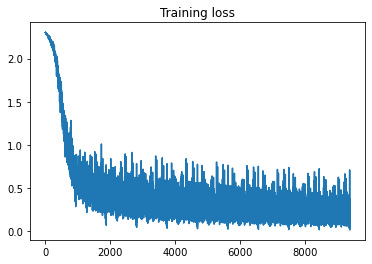

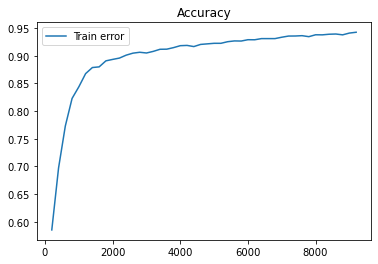

In [98]:
plt.title("Training loss")
plt.plot(loss_history)
plt.show()
steps, test_accuracy = zip(*test_accuracy_history)
#steps, train_accuracy = zip(*train_accuracy_history)

plt.title("Accuracy")
#plt.plot(steps, 1 - train_accuracy)
plt.plot(steps, test_accuracy)
plt.legend(["Train error", "Test error"])
plt.show()

# Evaluating model

## Fusing batch normalization layer

In [273]:
norm_term = torch.sqrt(model.bn.running_var + model.bn.eps)
bn_weight = torch.diag(model.bn.weight / norm_term)
bn_bias = model.bn.bias - model.bn.running_mean * model.bn.weight / norm_term
weight = model.fc.weight @ bn_weight
bias = bn_weight @ model.fc.bias + bn_bias

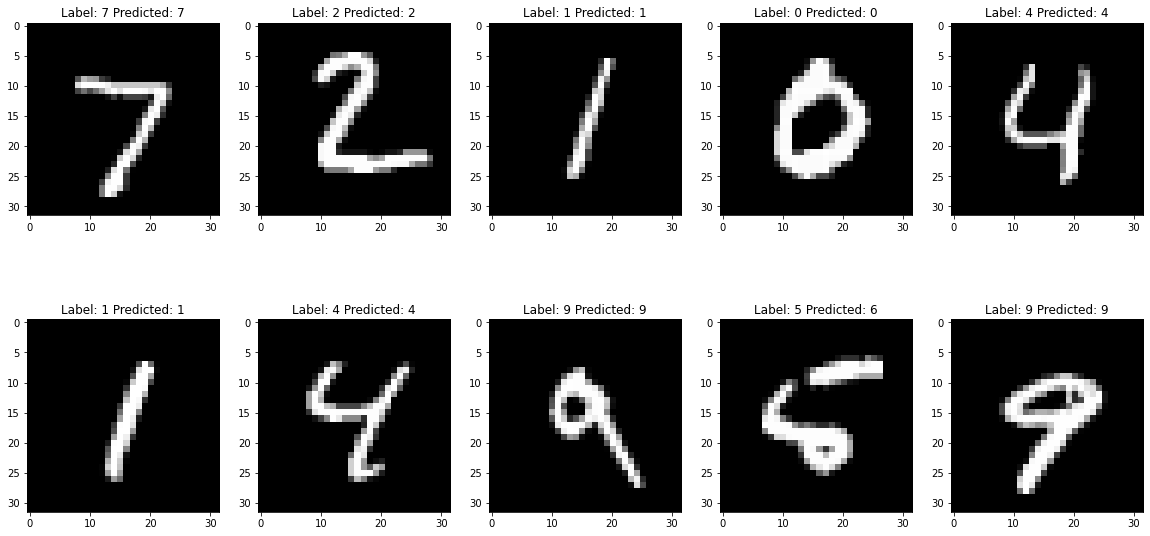

In [220]:
model.eval()
rows = 2
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))

for row in range(rows):
  for col in range(cols):
    image, label = test_dataset[row * cols + col]
    image = image[None, :].to(device)
    
    input_image = image
    if dense:
      input_image = input_image.flatten(start_dim=1)

    if spiking:
      input_image = input_image * 50 + 50

    out = model(input_image)

    axs[row][col].set_title("Label: {} Predicted: {}".format(label, out.argmax().item()))
    axs[row][col].imshow(image[0][0].cpu().numpy(), cmap="gray")

# Making it spike!

## Alpha filter

In [607]:
def alpha_filter(t, t_s=0.00118):
  return t / t_s * torch.exp(-t/t_s)

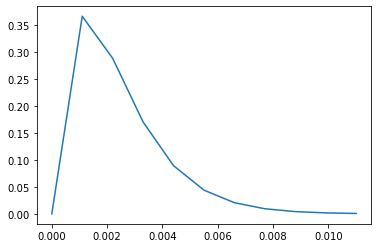

In [608]:
xs = torch.linspace(0, 0.011, 11)
ys = alpha_filter(xs)
plt.plot(xs, ys)
plt.show()


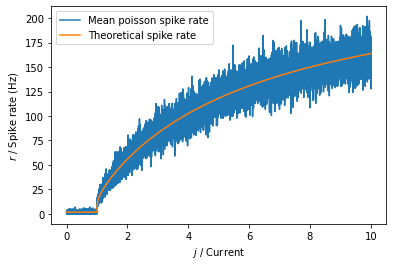

In [613]:
output = []
for current in torch.linspace(0, 10, 10000):
  spike_rate = rate(current) * 1e-3
  spikes = torch.poisson(torch.ones(1000) * spike_rate)
  convolved = F.conv1d(spikes[None, None, :], ys[None, None, :], stride=1)
  alpha_rate = convolved.mean()
  std = convolved.std()

  output.append((current, spikes, spike_rate, alpha_rate, std))

current, spikes, spike_rates, alpha_rates, stds  = zip(*output)
spikes = torch.stack(spikes)
alpha_rates = torch.stack(alpha_rates)
spike_rates = torch.stack(spike_rates)

stds = spikes.std(dim=1)
#plt.plot(current, spikes.mean(dim=1) * 1000)
plt.plot(current, alpha_rates * 1000)
#plt.errorbar(current, alpha_rates * 1000, stds)
#plt.fill_between(current, alpha_rates * 1000 - stds, alpha_rates * 1000 + stds, alpha=0.2, color="red")
plt.plot(current, spike_rates * 1000)
plt.legend(["Mean poisson spike rate", "Theoretical spike rate"])
plt.xlabel("$j$ / Current")
plt.ylabel("$r$ / Spike rate (Hz)")
plt.show()

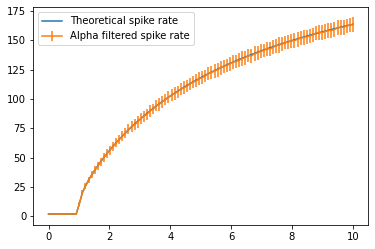

In [379]:
output = []
for current in torch.linspace(0, 10, 100):
  spike_rate = rate(current)
  inp = torch.poisson(torch.ones(1000) * spike_rate)
  convolved = F.conv1d(inp[None, None, :], ys[None, None, :], stride=1)
  alpha_rate = convolved.mean()
  std = convolved.std()

  output.append((current, spike_rate, alpha_rate, std))

current, spike_rates, alpha_rates, stds  = zip(*output)

plt.plot(current, spike_rates)
plt.errorbar(current, alpha_rates, stds)
plt.legend(["Theoretical spike rate", "Alpha filtered spike rate"])
plt.show()

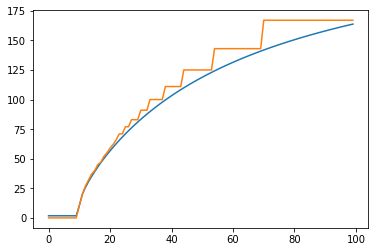

In [234]:
num_neurons = 100

dt = 1e-3 # 0.1ms simulation
time_steps = int(1 / dt) # 10 secs

input_current = torch.linspace(0.0, 10, num_neurons)
real_rates = rate(input_current)

v = torch.zeros(num_neurons) # Output neurons
timeouts = torch.zeros(num_neurons)
vs = []
spikes = torch.zeros(time_steps, num_neurons)

for i in range(time_steps):
  timeouts[timeouts > 0] -= dt
  input_current = input_current
  dv = (-v + input_current) / T_RC
  v[timeouts <= 0] += dt * dv[timeouts <= 0]

  # Reset spikes
  spikes[i, v > 1] = 1
  timeouts[v > 1] = T_REF
  v[v > 1] = 0
  
  vs.append(v.clone())

vs = torch.stack(vs)
""" 
# Show spikes
fig, ax = plt.subplots(num_neurons, 1, figsize=(30, 20))
vs = torch.stack(vs).detach().numpy()
for i in range(num_neurons):
  ax[i].set_title(i)
  ax[i].plot(vs[:, i])
plt.show()

fig, ax = plt.subplots(num_neurons, 1, figsize=(30, 20))
for i in range(num_neurons):
  ax[i].set_title(i)
  ax[i].plot(spikes[:, i])
plt.show()
"""

plt.plot(real_rates)
plt.plot(spikes.sum(dim=0))
plt.show()


## Possion rate coding

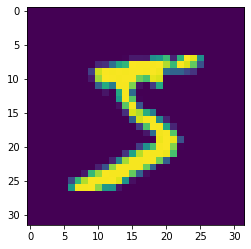

In [377]:
image, label = train_dataset[0]

image = image.flatten()
image = image * scaling_factor + bias_factor

dt = 1e-3                # 1ms time step
time_steps = int(1/dt)   # Simulate 1 second

input_spikes = torch.poisson(image.repeat(time_steps, 1))

plt.imshow(input_spikes.mean(axis=0).reshape(32, 32))
plt.show()

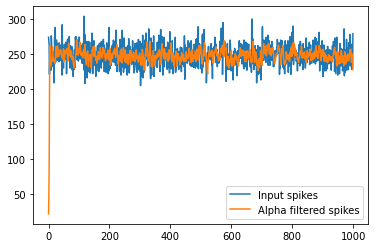

In [378]:
filtered_spikes = F.conv1d(input_spikes.T[None], ys[None, None, :].expand(32*32, -1, -1), stride=1, padding=5, groups=1024).T[:, :, 0]

plt.plot(input_spikes.reshape(-1, 32, 32)[:, 10, 15])
plt.plot(filtered_spikes.reshape(-1, 32, 32)[:, 10, 15])
plt.legend(["Input spikes", "Alpha filtered spikes"])
plt.show()

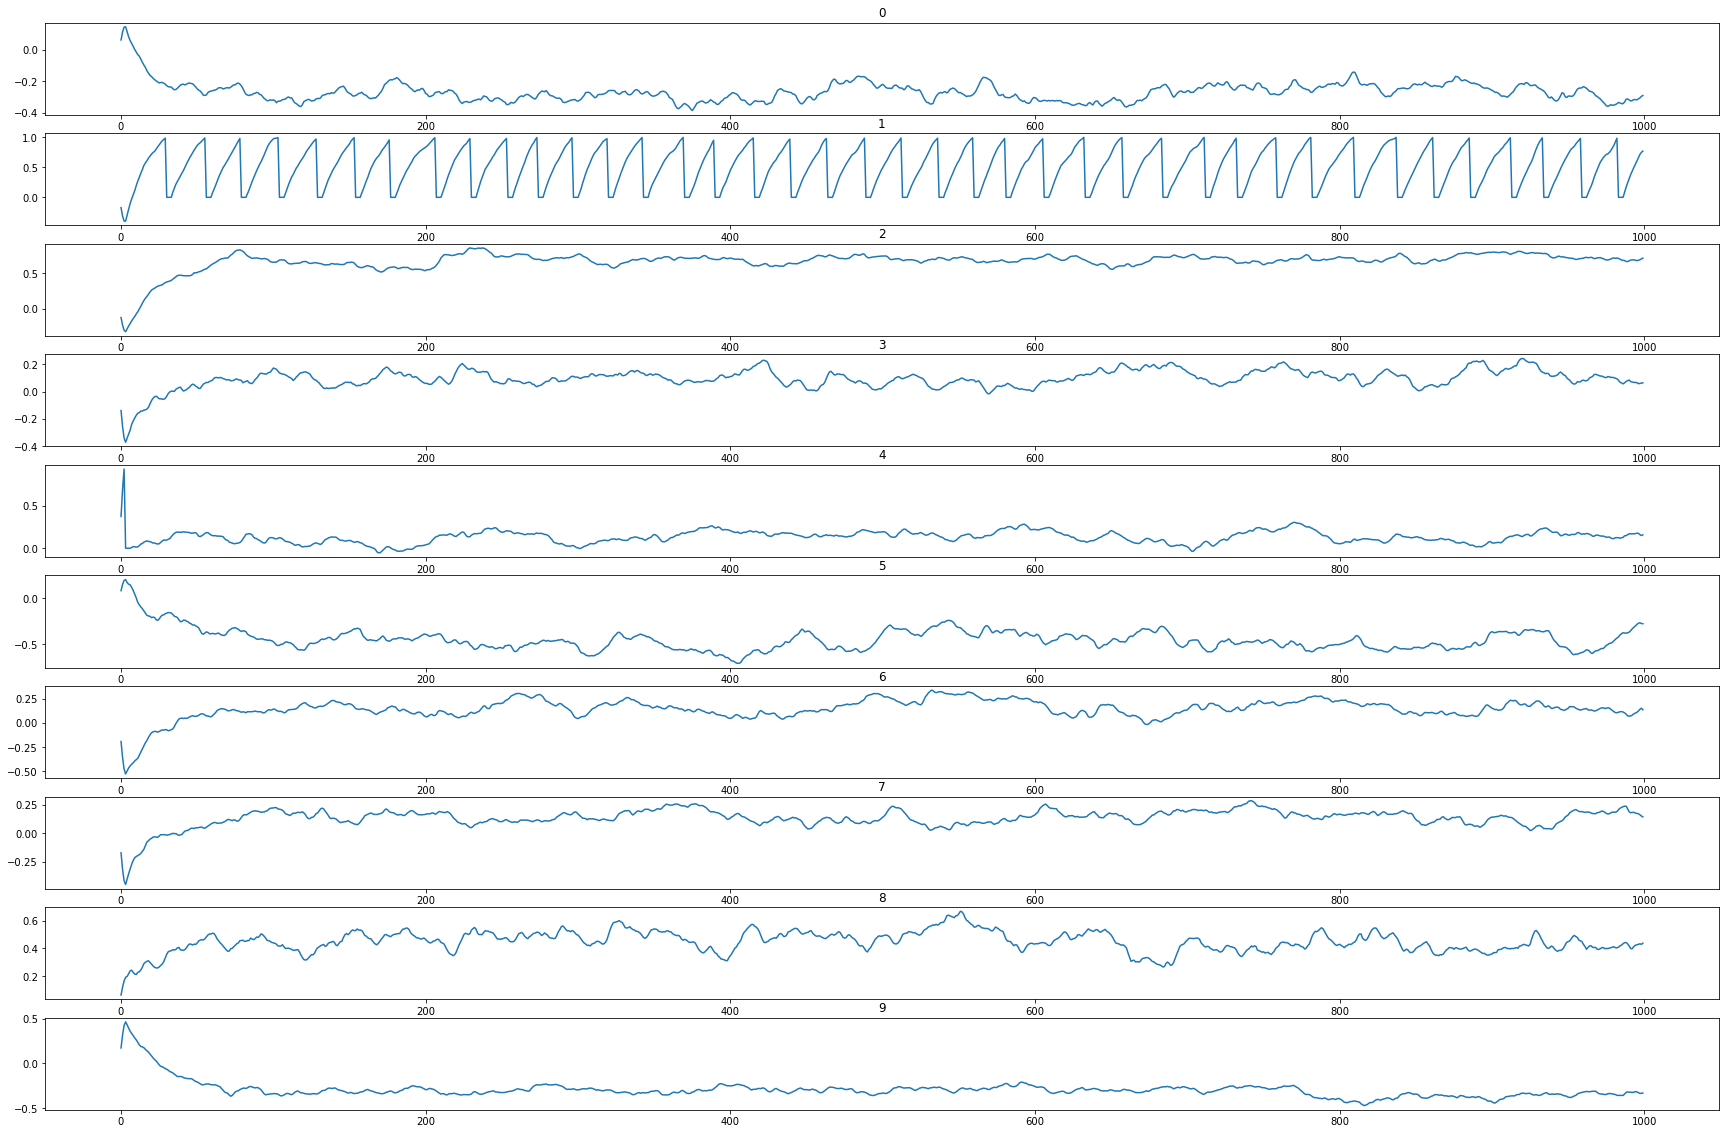

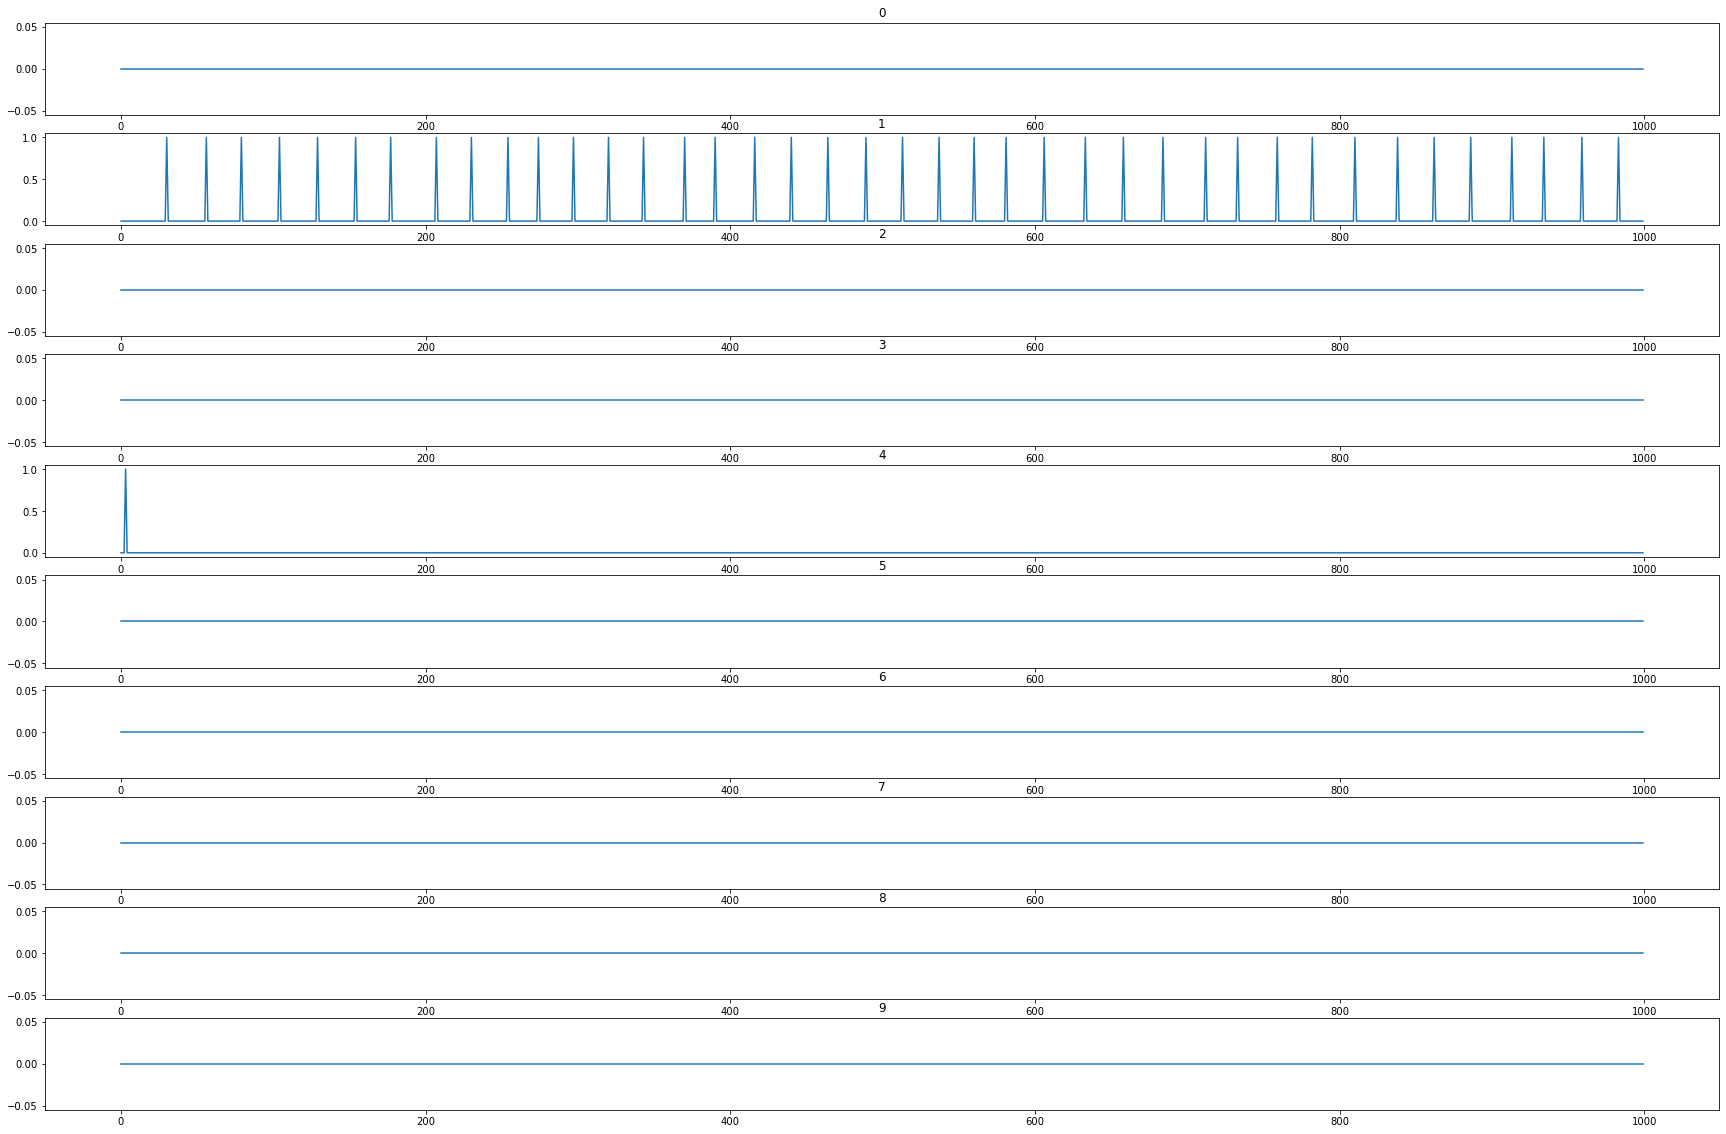

In [291]:
num_neurons = 10
v = torch.zeros(num_neurons) # Output neurons
timeouts = torch.zeros(num_neurons)
vs = []
spikes = torch.zeros(time_steps, num_neurons)


for i in range(time_steps):
  timeouts[timeouts > 0] -= dt
  input_current = filtered_spikes[i] @ weight + bias
  dv = (-v + input_current) / T_RC
  v[timeouts <= 0] += dt * dv[timeouts <= 0]

  # Reset spikes
  spikes[i, v > 1] = 1
  timeouts[v > 1] = T_REF
  v[v > 1] = 0
  
  vs.append(v.clone())


fig, ax = plt.subplots(10, 1, figsize=(30, 20))
vs = torch.stack(vs).detach().numpy()
for i in range(num_neurons):
  ax[i].set_title(i)
  ax[i].plot(vs[:, i])
plt.show()


fig, ax = plt.subplots(10, 1, figsize=(30, 20))
for i in range(num_neurons):
  ax[i].set_title(i)
  ax[i].plot(spikes[:, i])
plt.show()

In [218]:
#model.net[0].linear.weight


Parameter containing:
tensor([[ 1.2287e-02, -2.8085e-02, -1.8277e-02,  ...,  2.9617e-02,
          1.4731e-02,  1.9353e-02],
        [ 1.0003e-02,  1.6922e-03,  2.5152e-02,  ..., -3.9165e-03,
          2.7408e-03, -1.5760e-02],
        [-2.7963e-02, -7.6732e-03,  6.9797e-05,  ...,  1.9579e-02,
         -8.2507e-03,  1.9380e-02],
        ...,
        [-3.0230e-02,  1.3872e-02,  2.9394e-02,  ...,  2.0188e-02,
          2.1353e-02,  1.6961e-02],
        [-6.1589e-03,  2.3629e-02,  2.4520e-02,  ..., -8.1851e-03,
          7.6081e-03, -2.7382e-02],
        [-2.9501e-02,  4.1600e-03, -1.2889e-02,  ...,  4.4827e-03,
         -1.3683e-02, -2.2492e-02]], requires_grad=True)

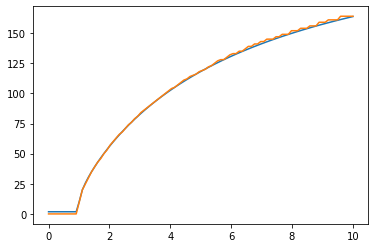

In [201]:
input_current = torch.linspace(0.0, 10, 100)
response = rate(input_current)

secs = 1
dt = 1e-4
steps = int(secs / dt)
v = torch.zeros(100)
timeouts = torch.zeros(100)
vs = []
spikes = torch.zeros(steps, 100)
for i in range(steps):
  timeouts[timeouts > 0] -= dt
  dv = (-v + input_current) / T_RC
  v[timeouts <= 0] += dt * dv[timeouts <= 0]

  # Reset spikes
  spikes[i, v > 1] = 1
  timeouts[v > 1] = T_REF
  v[v > 1] = 0
  
  vs.append(v.clone())

vs = torch.stack(vs)
plt.plot(input_current, response)
plt.plot(input_current, spikes.sum(dim=0))
plt.show()

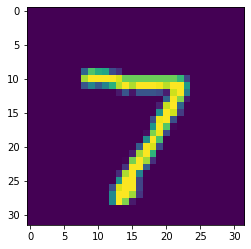

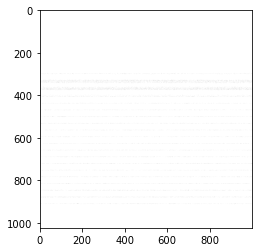

torch.Size([600, 1024])


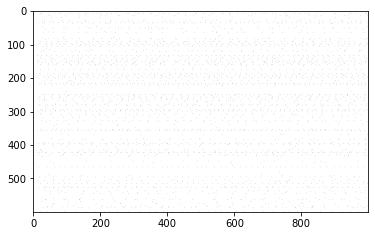

torch.Size([600, 600])


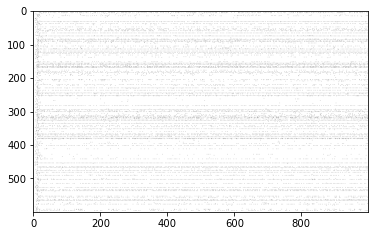

torch.Size([10, 600])


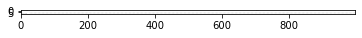

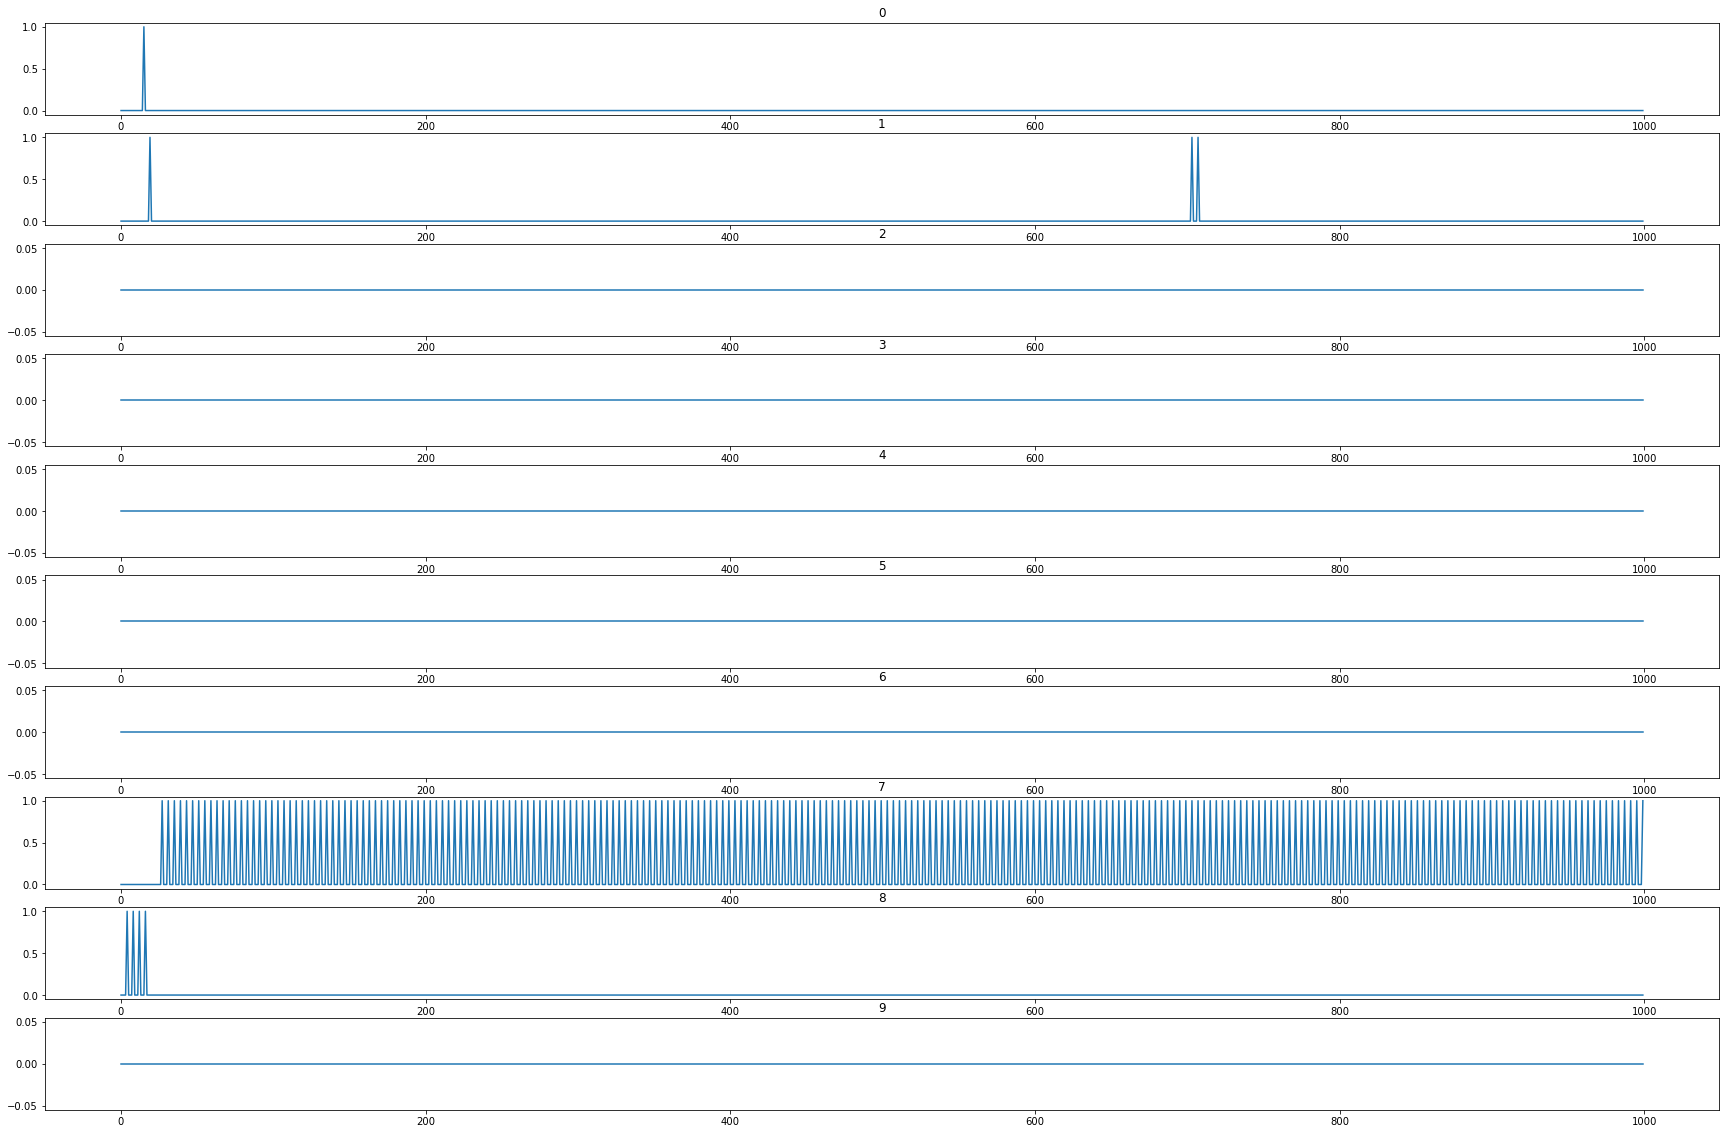

Prediction: 7


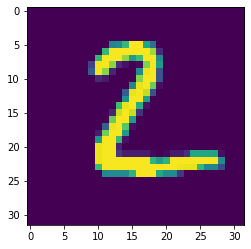

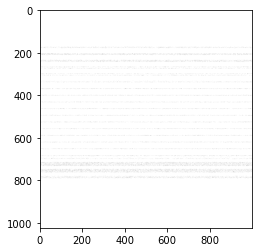

torch.Size([600, 1024])


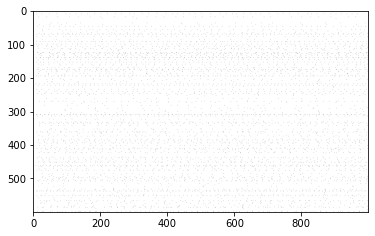

torch.Size([600, 600])


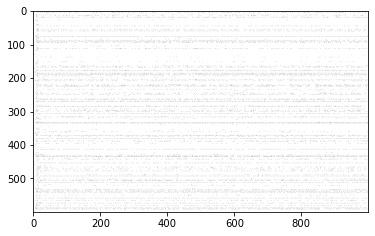

torch.Size([10, 600])


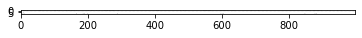

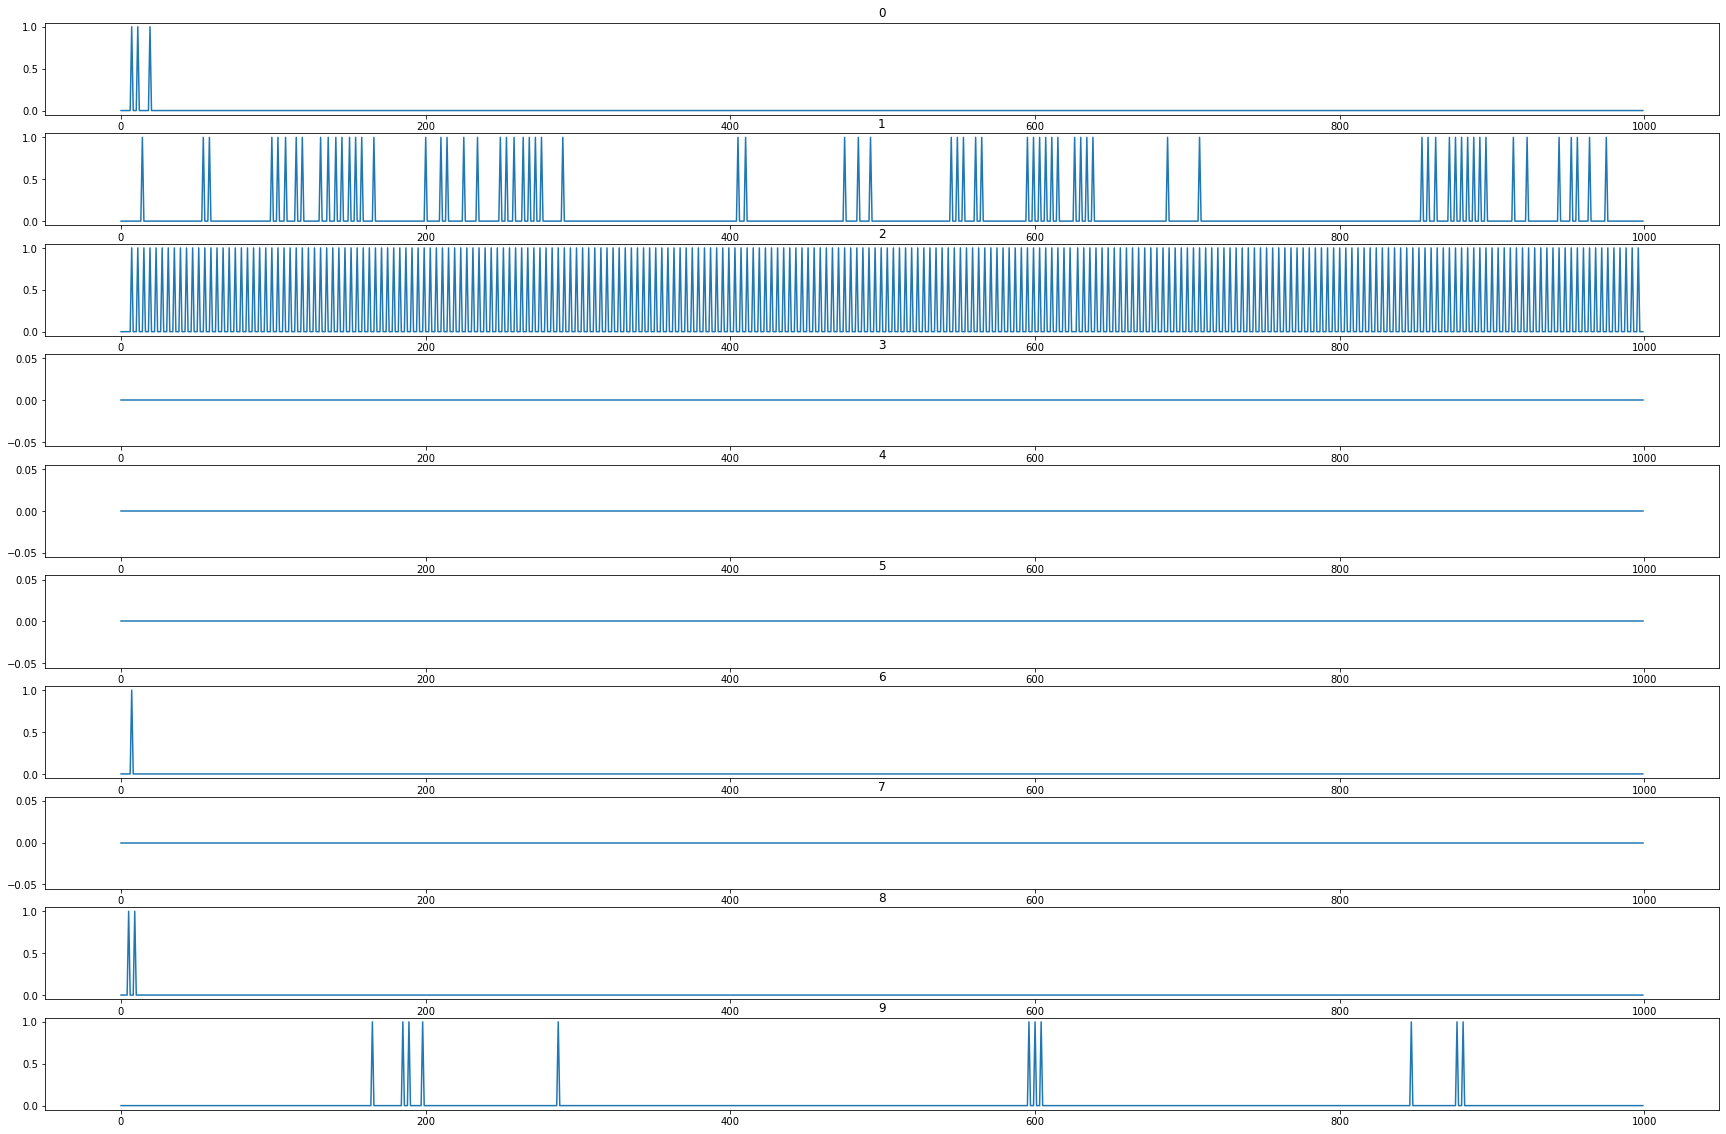

Prediction: 2


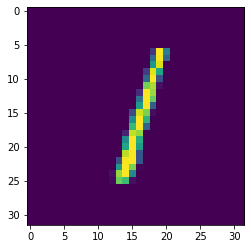

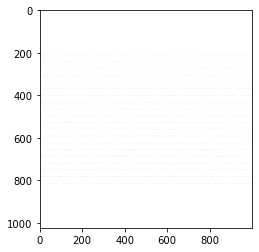

torch.Size([600, 1024])


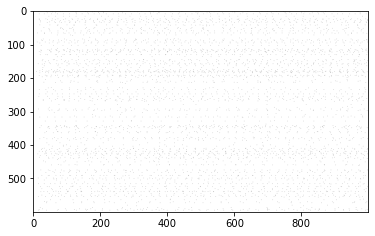

torch.Size([600, 600])


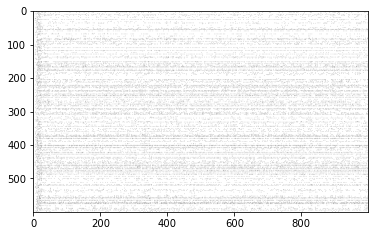

torch.Size([10, 600])


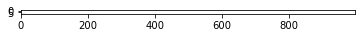

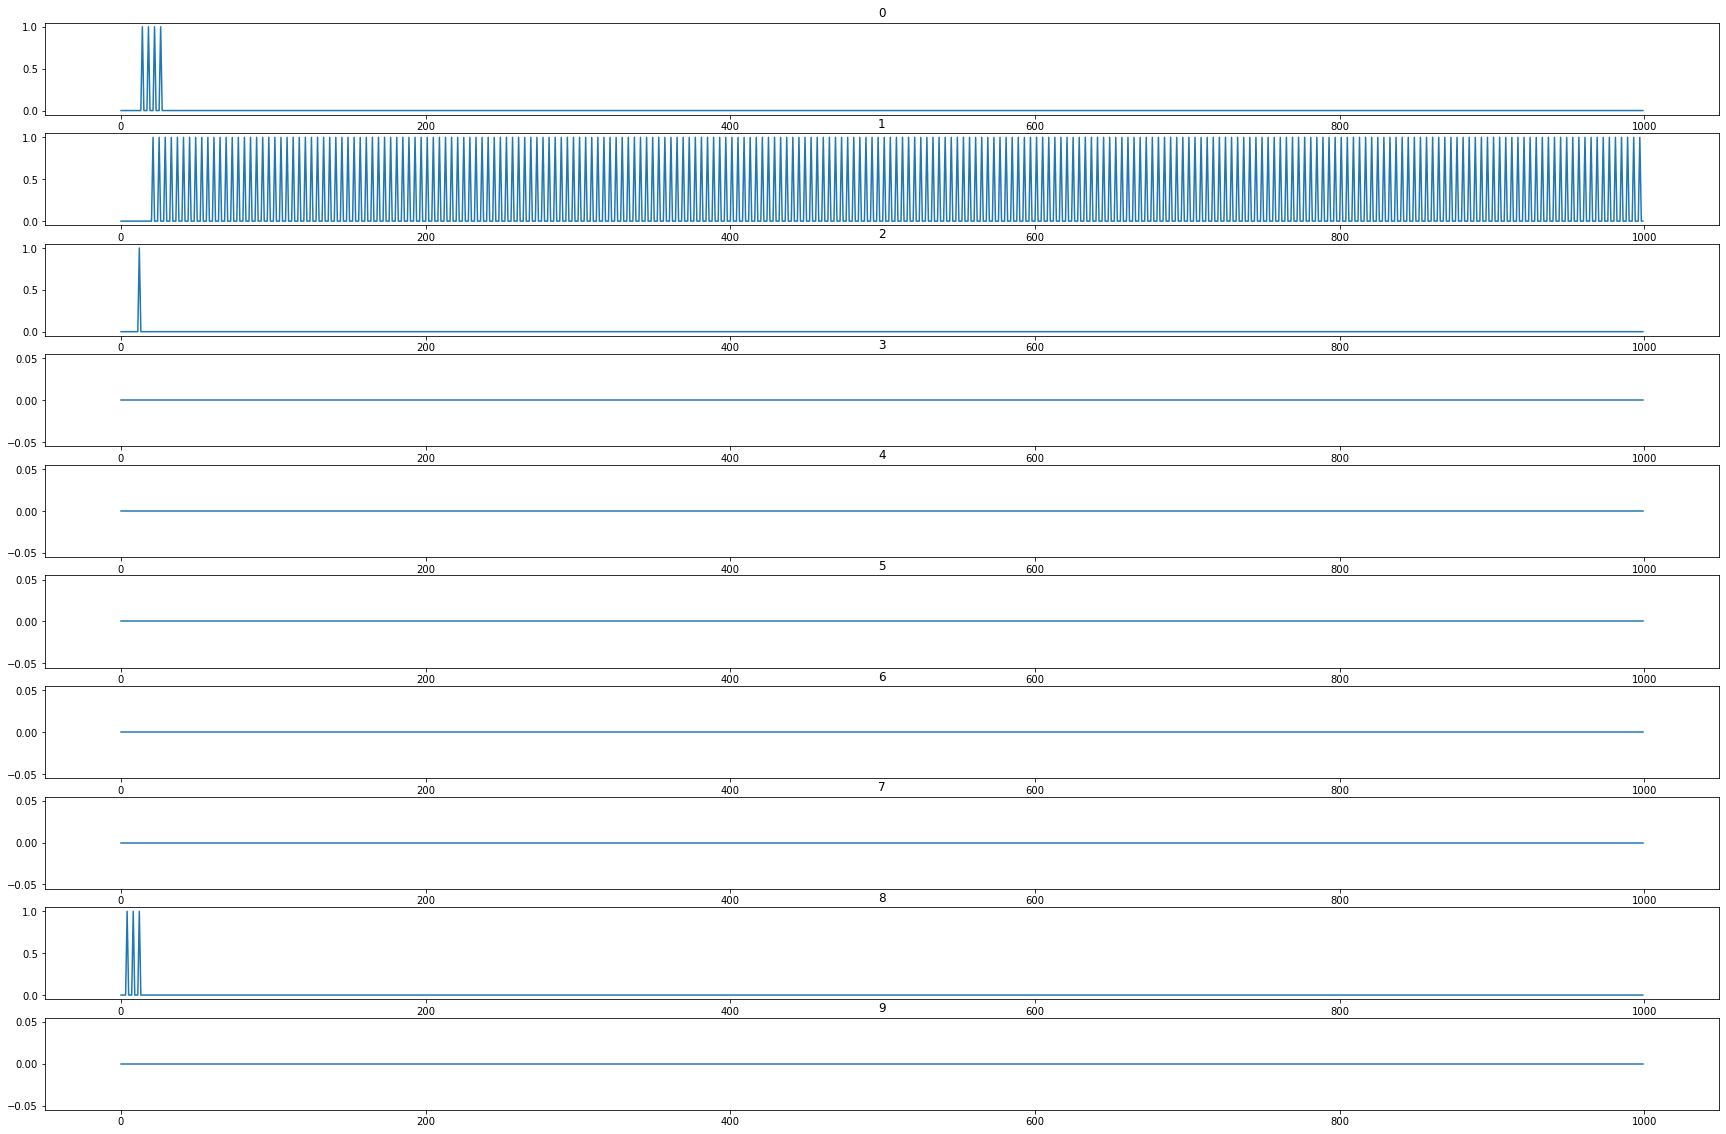

Prediction: 1


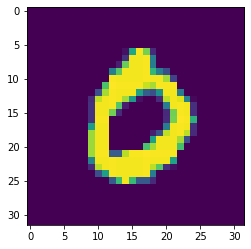

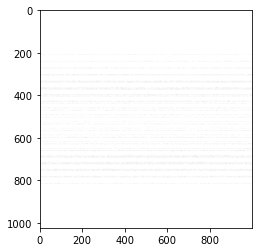

torch.Size([600, 1024])


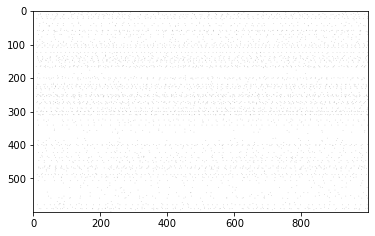

torch.Size([600, 600])


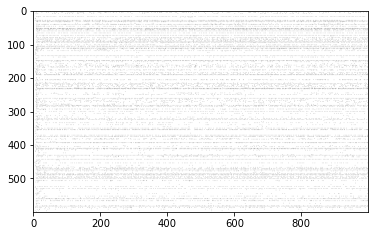

torch.Size([10, 600])


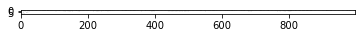

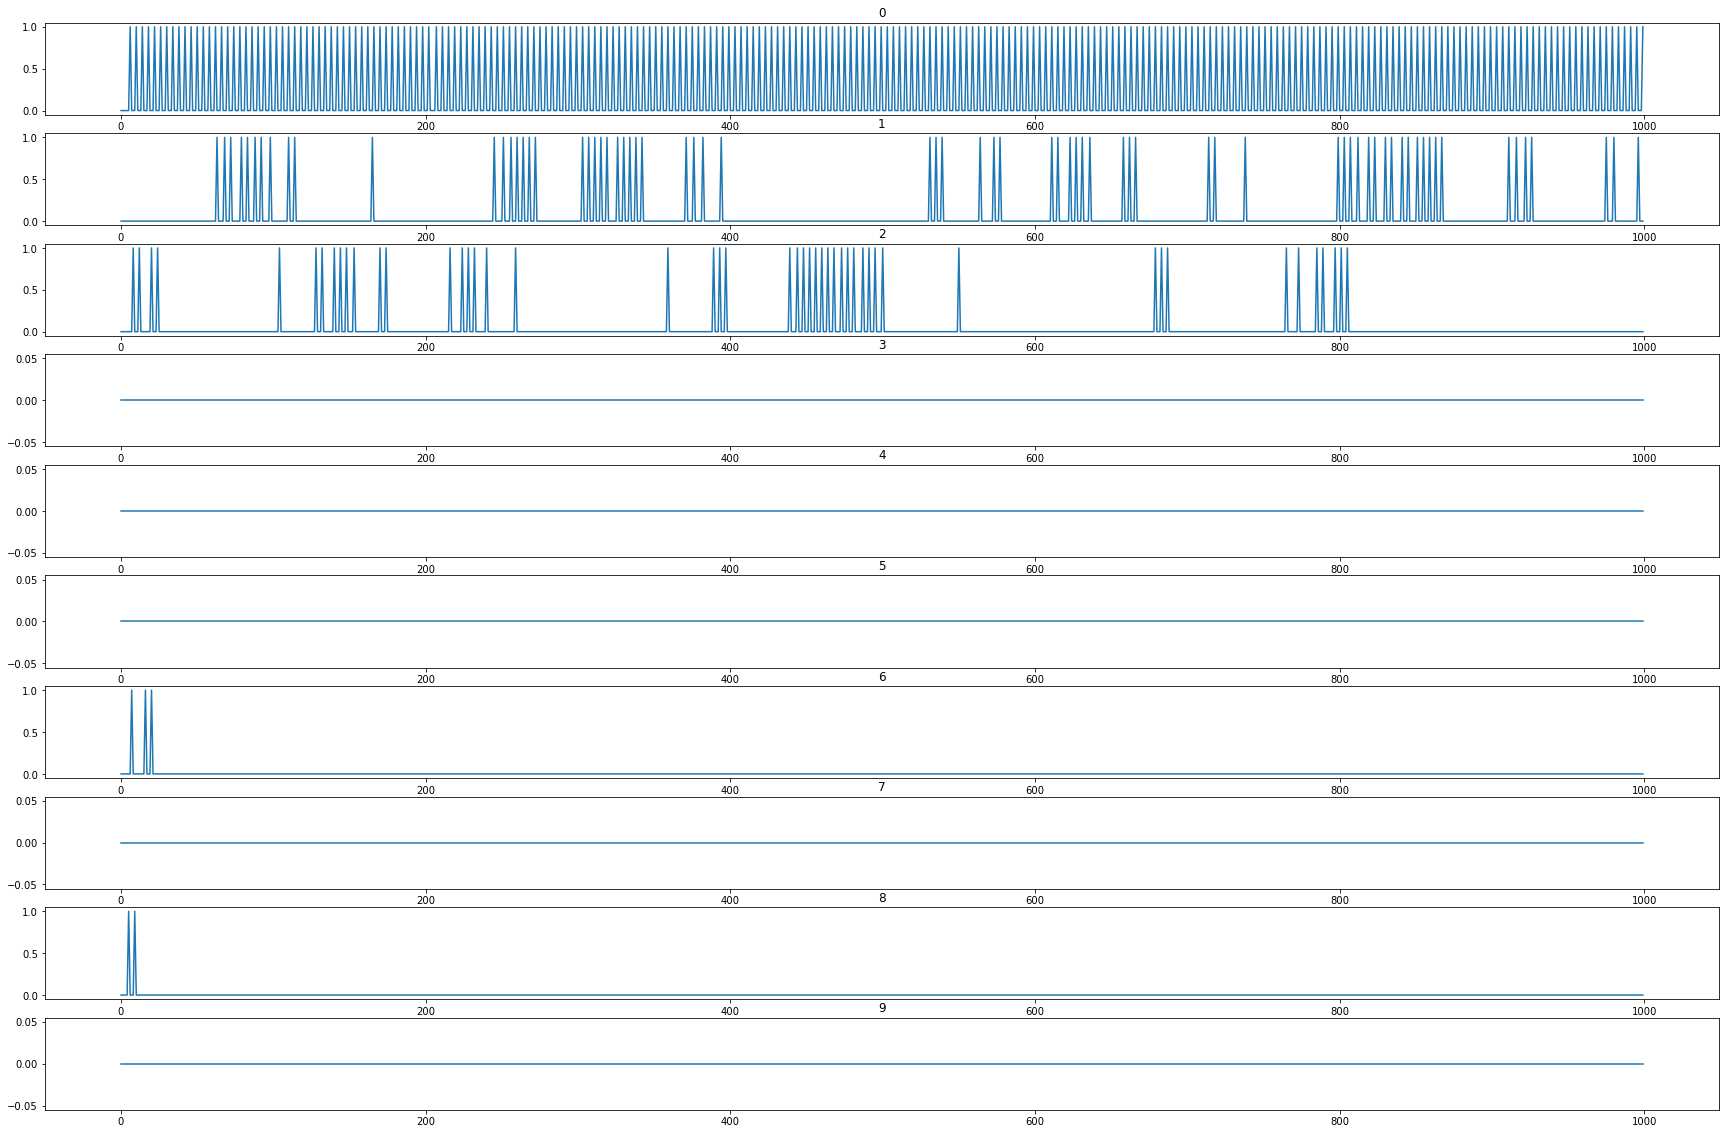

Prediction: 0


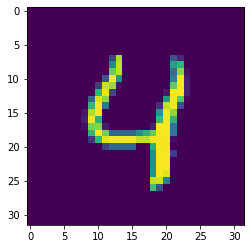

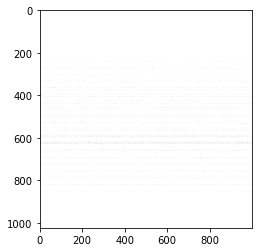

torch.Size([600, 1024])


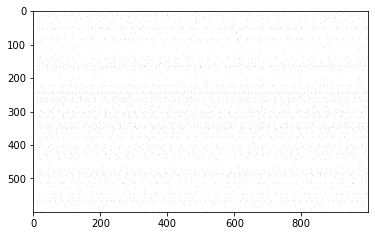

torch.Size([600, 600])


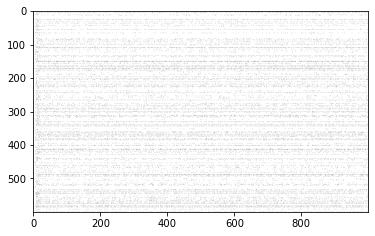

torch.Size([10, 600])


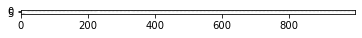

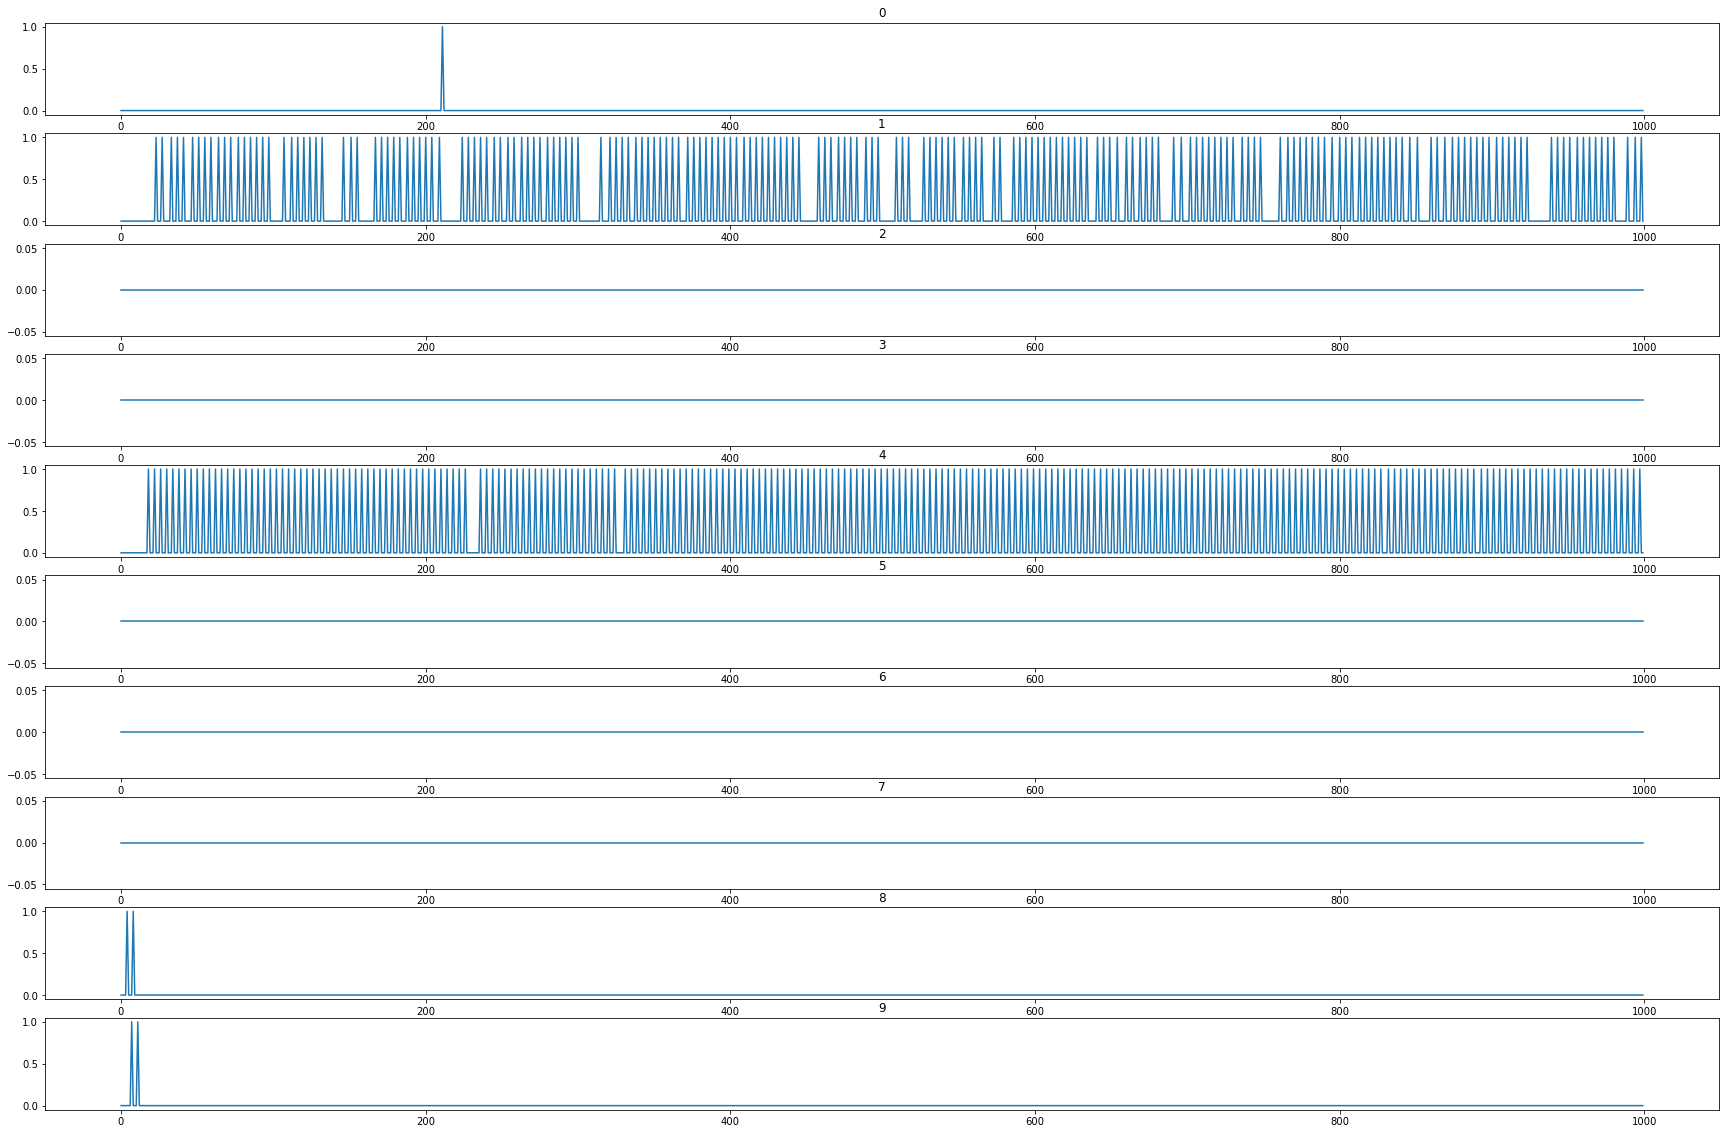

Prediction: 4


In [606]:
for n in range(5):
  image, label = test_dataset[n]

  image = image.flatten()
  image = image * scaling_factor + bias_factor

  dt = 1e-3                       # 1ms time step
  num_secs = 1                    # Number of seconds to simulate
  time_steps = int(num_secs / dt) # How many timesteps of dt for num_secs

  # Poisson encode the image
  spikes = torch.poisson(image.repeat(time_steps, 1) * dt)

  # Show the image
  plt.imshow(image.reshape(32, 32))
  plt.show()

  # Show the input spikes
  plt.imshow(spikes.T, cmap="gray_r")
  plt.show()


  for m in model.net:
    print(m.linear.weight.shape)
    # Fuse batch norm layer
    norm_term = torch.sqrt(m.bn.running_var + m.bn.eps)
    bn_weight = torch.diag(m.bn.weight / norm_term)
    bn_bias = m.bn.bias - m.bn.running_mean * m.bn.weight / norm_term
    weight = bn_weight @ m.linear.weight
    bias = bn_weight @ m.linear.bias + bn_bias

    num_neurons, num_inputs = m.out_features, m.in_features
    # Input current to all neurons in layer
    input_current = (F.conv1d(spikes.T[None], ys[None, None, :].expand(num_inputs, -1, -1), stride=1, padding=5, groups=num_inputs).T[:, :, 0] / dt * 0.05) @ weight.T + bias
    #last_spikes = spikes @ W.T + b
    timeouts = torch.zeros(num_neurons)
    v = torch.zeros(num_neurons)
    spikes = torch.zeros(time_steps, num_neurons)

    # Simulate time steps here
    for i in range(time_steps):
      timeouts[timeouts > 0] -= dt
      dv = (-v + input_current[i]) / T_RC
      #dv = (-v + last_spikes[i]) / T_RC
      v[timeouts <= 0] += dt * dv[timeouts <= 0]

      # Reset spikes
      spikes[i, v > 1] = 1
      timeouts[v > 1] = T_REF
      v[v > 1] = 0


    #Image.fromarray(spikes.T.numpy() * 255).show()
    plt.imshow(spikes.T, cmap="gray_r")
    plt.show()


  fig, ax = plt.subplots(10, 1, figsize=(30, 20))
  for i in range(10):
    ax[i].set_title(i)
    ax[i].plot(spikes[:, i])
  plt.show()

  pred = spikes.sum(dim=0).argmax().item()
  print(f"Prediction: {pred}")